In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [4]:
data = pd.read_csv('both.csv')

In [3]:
#data.drop()

In [8]:
!pip install spektral

In [5]:
#startign graphcnn

In [23]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from spektral.datasets import qm9
from spektral.layers import EdgeConditionedConv, GlobalSumPool
from spektral.utils import label_to_one_hot
from spektral.chem import sdf_to_nx

In [7]:
################################################################################
# PARAMETERS
################################################################################
learning_rate = 1e-3  # Learning rate
epochs = 10           # Number of training epochs
batch_size = 32           # Batch size

In [26]:
################################################################################
# LOAD DATA
################################################################################
A, X, E, y = qm9.load_data(return_type='numpy',
                           nf_keys='atomic_num',
                           ef_keys='type',
                           self_loops=True,
                           amount=None)  # Set to None to train on whole dataset
y = y[['cv']].values  # Heat capacity at 298.15K

Loading QM9 dataset.
Reading SDF


In [27]:
A.shape,X.shape,E.shape,y.shape

((133885, 9, 9), (133885, 9, 1), (133885, 9, 9, 1), (133885, 1))

In [28]:
# Preprocessing
X_uniq = np.unique(X)
X_uniq = X_uniq[X_uniq != 0]
E_uniq = np.unique(E)
E_uniq = E_uniq[E_uniq != 0]

X = label_to_one_hot(X, X_uniq)
E = label_to_one_hot(E, E_uniq)

In [29]:
# Parameters
N = X.shape[-2]       # Number of nodes in the graphs
F = X[0].shape[-1]    # Dimension of node features
S = E[0].shape[-1]    # Dimension of edge features
n_out = y.shape[-1]   # Dimension of the target

In [30]:
A_train, A_test, \
X_train, X_test, \
E_train, E_test, \
y_train, y_test = train_test_split(A, X, E, y, test_size=0.1, random_state=0)

In [31]:
del model

In [32]:
################################################################################
# BUILD MODEL
################################################################################
X_in = Input(shape=(N, F))
A_in = Input(shape=(N, N))
E_in = Input(shape=(N, N, S))

X_1 = EdgeConditionedConv(32, activation='relu')([X_in, A_in, E_in])
X_2 = EdgeConditionedConv(32, activation='relu')([X_1, A_in, E_in])
X_3 = GlobalSumPool()(X_2)
output = Dense(n_out)(X_3)

# Build model
model = Model(inputs=[X_in, A_in, E_in], outputs=output)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 9, 4)]       0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 9, 9)]       0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 9, 9, 3)]    0                                            
__________________________________________________________________________________________________
edge_conditioned_conv_2 (EdgeCo (None, 9, 32)        672         input_4[0][0]                    
                                                                 input_5[0][0]              

In [33]:
################################################################################
# FIT MODEL
################################################################################
model.fit([X_train, A_train, E_train],y_train,batch_size=batch_size,epochs=epochs)

Epoch 1/10
3766/3766 [==============================] - 30s 8ms/step - loss: 6.3975
Epoch 2/10
3766/3766 [==============================] - 29s 8ms/step - loss: 0.6460
Epoch 3/10
3766/3766 [==============================] - 29s 8ms/step - loss: 0.5804
Epoch 4/10
3766/3766 [==============================] - 29s 8ms/step - loss: 0.5605
Epoch 5/10
3766/3766 [==============================] - 29s 8ms/step - loss: 0.5447
Epoch 6/10
3766/3766 [==============================] - 29s 8ms/step - loss: 0.5270
Epoch 7/10
3766/3766 [==============================] - 30s 8ms/step - loss: 0.5115
Epoch 8/10
3766/3766 [==============================] - 29s 8ms/step - loss: 0.5052
Epoch 9/10
3766/3766 [==============================] - 29s 8ms/step - loss: 0.4937
Epoch 10/10
3766/3766 [==============================] - 29s 8ms/step - loss: 0.4891


In [35]:
print('Testing model')
model_loss = model.evaluate([X_test, A_test, E_test],y_test, batch_size=batch_size)
print('Done. Test loss: {}'.format(model_loss))

Testing model
419/419 [==============================] - 2s 5ms/step - loss: 0.4966
Done. Test loss: 0.4965742528438568


In [36]:
y_test.shape

(13389, 1)

In [37]:
y_predict = model.predict([X_test, A_test, E_test],batch_size=batch_size)
y_predict.shape

(13389, 1)

In [38]:
from sklearn.metrics import r2_score
print (r2_score(y_test, y_predict))

0.9701293407903547


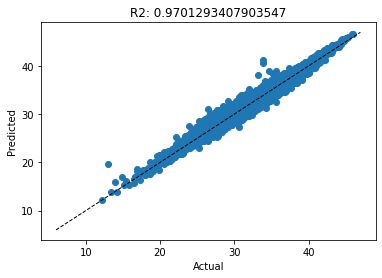

In [39]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_predict)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('R2: ' + str(r2_score(y_test, y_predict)))

#regression line
#y_test, y_predict = y_test.reshape(-1,1), y_predict.reshape(-1,1)
#ax.plot(y_test, LinearRegression().fit(y_test, y_predict).predict(y_test))


plt.show()

In [1]:
#trained first graphCNN of my life

In [13]:
!conda install -c conda-forge rdkit

/bin/bash: conda: command not found


In [5]:
#!wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
#!chmod +x Anaconda3-2019.10-Linux-x86_64.sh
#!bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local
#!conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [6]:
data

,Unnamed: 0,drug,smile,mol_logp
0,0,CHEMBL10,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,4.68220
1,1,CHEMBL1000,O=C(O)COCCN1CCN(C(c2ccccc2)c2ccc(Cl)cc2)CC1,3.14820
2,2,CHEMBL100012,CC(C)(C)c1cnc(CSc2cnc(Nc3cccnc3)s2)o1,4.85950
3,3,CHEMBL100016,Oc1cccc(/C=C/c2cccc(O)c2)c1,3.26820
4,4,CHEMBL100050,CN1/C(=C(C#N)\C(C#N)=C2\Sc3ccccc3N2C)Sc2ccccc21,4.94096
...,...,...,...,...
52033,52033,CHEMBL99852,Oc1cccc(/C=C/c2cc(O)cc(O)c2)c1,2.97380
52034,52034,CHEMBL99859,COc1ccc(CNc2ncnc3c2ncn3C(C)C)cc1,3.02790
52035,52035,CHEMBL99923,C[C@H]1O[C@@H](n2cc(I)c3c(Nc4ccc(C#N)cc4)ncnc3...,2.29028
52036,52036,CHEMBL99948,Cc1ccc(Cl)c(Nc2ccnc(Nc3ccc(OCC(O)CN(C)C)cc3)n2)c1,4.22692


In [7]:
smile = data['smile'].values

In [8]:
len(smile)

52038

In [16]:
!conda install -c rdkit rdkit

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - failed with initial frozen solve. Retrying with flexible solve.
Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: / - \ | / - \ | / - \ | 

In [17]:
from rdkit import Chem

In [18]:
mols = [ Chem.MolFromSmiles(item) for item in smile]

In [19]:
len(mols)

52038

In [20]:
w = Chem.SDWriter('drugs_kiba.sdf')
for m in mols:
  w.write(m)

In [6]:
#own dataset analysis

In [5]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [26]:
from spektral.layers import GraphAttention, GlobalAttentionPool,GlobalSumPool,EdgeConditionedConv
from spektral.utils import label_to_one_hot, load_sdf, nx_to_numpy
from spektral.chem import sdf_to_nx

In [8]:
n_mols = 1000

In [11]:
sdf_loaded = load_sdf('drugs_kiba.sdf', amount=n_mols)

Reading SDF


In [12]:
sdf_nx = sdf_to_nx(sdf_loaded, keep_hydrogen=False)

In [13]:
len(sdf_nx)

1000

In [18]:
y = np.asarray(data[:n_mols]['mol_logp'].values).reshape(-1,1)

In [15]:
sdf_adj, sdf_node, sdf_edge = nx_to_numpy(sdf_nx,self_loops=True,nf_keys=['atomic_num'],ef_keys=['type'])

In [19]:
sdf_adj.shape, sdf_node.shape, sdf_edge.shape, y.shape

((1000, 115, 115), (1000, 115, 1), (1000, 115, 115, 1), (1000, 1))

In [17]:
# Preprocessing
X_uniq = np.unique(sdf_node)
X_uniq = X_uniq[X_uniq != 0]
E_uniq = np.unique(sdf_edge)
E_uniq = E_uniq[E_uniq != 0]

X = label_to_one_hot(sdf_node, X_uniq)
E = label_to_one_hot(sdf_edge, E_uniq)

In [20]:
# Parameters
N = sdf_node.shape[-2]       # Number of nodes in the graphs
F = sdf_node[0].shape[-1]    # Dimension of node features
S = sdf_edge[0].shape[-1]    # Dimension of edge features
n_out = y.shape[-1]   # Dimension of the target

In [21]:
N,F,S,n_out

(115, 1, 1, 1)

In [23]:
A_train, A_test, X_train, X_test, E_train, E_test, y_train, y_test = train_test_split(sdf_adj, sdf_node, sdf_edge, y, test_size=0.1, random_state=0)

In [31]:
################################################################################
# PARAMETERS
################################################################################
learning_rate = 1e-3  # Learning rate
epochs = 10           # Number of training epochs
batch_size = 32      #batch size

In [48]:
es_patience = 5                # Patience for early stopping
es_delta = 0.001                # Min Delta for early stopping

In [50]:
del model

In [51]:
################################################################################
# BUILD MODEL
################################################################################
X_in = Input(shape=(N, F))
A_in = Input(shape=(N, N))
E_in = Input(shape=(N, N, S))

#X_1 = EdgeConditionedConv(32, activation='relu')([X_in, A_in, E_in])
#X_2 = EdgeConditionedConv(32, activation='relu')([X_1, A_in, E_in])
#X_3 = GlobalSumPool()(X_2)
#output = Dense(n_out)(X_3)


X_1 = GraphAttention(32, activation='relu')([X_in, A_in, E_in])
X_2 = GraphAttention(32, activation='relu')([X_1, A_in, E_in])
X_3 = GlobalAttentionPool(64)(X_2)
output = Dense(n_out)(X_3)



# Build model
model = Model(inputs=[X_in, A_in, E_in], outputs=output)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 115, 1)]     0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 115, 115)]   0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 115, 115, 1) 0                                            
__________________________________________________________________________________________________
graph_attention_2 (GraphAttenti (None, 115, 32)      128         input_4[0][0]                    
                                                                 input_5[0][0]              

In [52]:
################################################################################
# FIT MODEL
################################################################################
history  = model.fit([X_train, A_train, E_train],y_train,batch_size=batch_size,epochs=epochs,validation_split=0.1,callbacks=[cb_early])

Epoch 1/10
26/26 [==============================] - 1s 24ms/step - loss: 3.2725 - val_loss: 2.7727
Epoch 2/10
26/26 [==============================] - 0s 13ms/step - loss: 2.2922 - val_loss: 2.7539
Epoch 3/10
26/26 [==============================] - 0s 13ms/step - loss: 2.3962 - val_loss: 2.9518
Epoch 4/10
26/26 [==============================] - 0s 13ms/step - loss: 2.4112 - val_loss: 4.0256
Epoch 5/10
26/26 [==============================] - 0s 12ms/step - loss: 2.2095 - val_loss: 2.8636
Epoch 6/10
26/26 [==============================] - 0s 12ms/step - loss: 2.3521 - val_loss: 2.8493
Epoch 7/10
26/26 [==============================] - 0s 13ms/step - loss: 2.2624 - val_loss: 2.7883
Epoch 00007: early stopping


In [53]:
y_predict = model.predict([X_test, A_test, E_test],batch_size=batch_size)

In [54]:
from sklearn.metrics import r2_score
print (r2_score(y_test, y_predict))

-0.1970711989994438


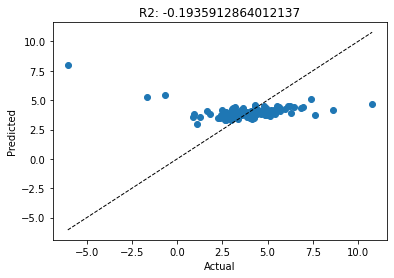

In [46]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_predict)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('R2: ' + str(r2_score(y_test, y_predict)))

#regression line
#y_test, y_predict = y_test.reshape(-1,1), y_predict.reshape(-1,1)
#ax.plot(y_test, LinearRegression().fit(y_test, y_predict).predict(y_test))


plt.show()

In [13]:
# below is from online tutorial, this works
# Node attributes preprocessing
# uniq_node = np.unique([v for x in sdf_node for v in np.unique(x)])
# node = np.asarray([label_to_one_hot(x, uniq_node) for x in sdf_node])

In [14]:

#logp = np.asarray(logp)

In [195]:
#logp = logp.

In [15]:
logp.shape

(5000, 1)

In [16]:
# Model parameters
N = node[0].shape[-2]          # Number of nodes in the graphs
F = node[0].shape[-1]          # Original feature dimensionality
#n_classes = label.shape[-1]    # Number of classes

l2_reg = 5e-4                  # Regularization rate for l2
learning_rate = 1e-4           # Learning rate for Adam
epochs = 100                     # Number of training epochs
batch_size = 32                # Batch size
es_patience = 5                # Patience for early stopping
es_delta = 0.001                # Min Delta for early stopping

print('Number of nodes in the graphs : ',N)
print('Features dimenssionality :',F)
#print('Number of classes :',n_classes)

Number of nodes in the graphs :  216
Features dimenssionality : 14


In [17]:
from sklearn.model_selection import train_test_split

In [18]:
# Train/test split : 10%
A_train, A_test, \
X_train, X_test, \
y_train, y_test = train_test_split(sdf_adj, node, y, test_size=0.1,random_state=0)

In [19]:
A_train.shape, X_train.shape, y_train.shape, A_test.shape, X_test.shape, y_test.shape

((4500, 216, 216),
 (4500, 216, 14),
 (4500, 1),
 (500, 216, 216),
 (500, 216, 14),
 (500, 1))

In [40]:
from tensorflow.keras import backend as K
K.clear_session()

In [212]:
# Model definition
X_in = Input(shape=(N, F))
A_in = Input((N, N))

gc1 = GraphAttention(64, activation='relu', kernel_regularizer=l2(l2_reg))([X_in, A_in])
gc2 = GraphAttention(64, activation='relu', kernel_regularizer=l2(l2_reg))([gc1, A_in])
pool = GlobalAttentionPool(128)(gc2)
#pool = GlobalSumPool()(gc2)

output = Dense(1, activation='linear')(pool)

In [213]:
del model

In [214]:
# Build model
model = Model(inputs=[X_in, A_in], outputs=output)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 216, 14)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 216, 216)]   0                                            
__________________________________________________________________________________________________
graph_attention (GraphAttention (None, 216, 64)      1088        input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
graph_attention_1 (GraphAttenti (None, 216, 64)      4288        graph_attention[0][0]        

In [215]:
del history

In [49]:
cb_early = EarlyStopping(monitor='val_loss', min_delta=es_delta, patience=es_patience, verbose=1, restore_best_weights=True)

In [216]:
# Train model : 10% validation split
history = model.fit([X_train, A_train],y_train,batch_size=batch_size,validation_split=0.1,epochs=epochs,callbacks=[cb_early])

Epoch 1/100
127/127 [==============================] - 3s 23ms/step - loss: 3.7293 - val_loss: 2.9566
Epoch 2/100
127/127 [==============================] - 3s 21ms/step - loss: 2.9478 - val_loss: 2.9048
Epoch 3/100
127/127 [==============================] - 3s 21ms/step - loss: 2.8310 - val_loss: 2.6414
Epoch 4/100
127/127 [==============================] - 3s 21ms/step - loss: 2.6133 - val_loss: 2.3059
Epoch 5/100
127/127 [==============================] - 3s 21ms/step - loss: 2.3813 - val_loss: 2.0483
Epoch 6/100
127/127 [==============================] - 3s 21ms/step - loss: 2.1854 - val_loss: 1.6917
Epoch 7/100
127/127 [==============================] - 3s 21ms/step - loss: 2.0872 - val_loss: 1.4661
Epoch 8/100
127/127 [==============================] - 3s 21ms/step - loss: 2.0861 - val_loss: 1.3687
Epoch 9/100
127/127 [==============================] - 3s 21ms/step - loss: 2.1019 - val_loss: 1.5862
Epoch 10/100
127/127 [==============================] - 3s 21ms/step - loss: 2.045

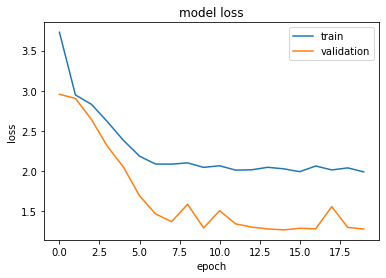

In [217]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [218]:
y_predict = model.predict([X_test, A_test],batch_size=batch_size)

In [219]:
from sklearn.metrics import r2_score
print (r2_score(y_test, y_predict))

0.46456643499208206
